<a href="https://colab.research.google.com/github/TaherAli331108/Time-Series-Forcasting-using-PyTorch/blob/main/Time_series_Forecasting_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference : https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [ ]:

import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

/kaggle/input/solarpanelspower/solarpower_cumuldaybyday2.csv
/kaggle/input/solarpanelspower/PV_Elec_Gas2.csv


In [ ]:
solar_power = pd.read_csv('/kaggle/input/solarpanelspower/PV_Elec_Gas2.csv').rename(columns={'Unnamed: 0':'timestamp'}).set_index('timestamp')

#### Train & Valid split(Almost 8.5:1.5)

In [ ]:
train_set = solar_power[:'2018-10-31']
valid_set = solar_power['2018-11-01':'2019-11-18']
print('Proportion of train_set : {:.2f}%'.format(len(train_set)/len(solar_power)))
print('Proportion of valid_set : {:.2f}%'.format(len(valid_set)/len(solar_power)))

Proportion of train_set : 0.87%
Proportion of valid_set : 0.13%


In [ ]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):

        end_ix = i + n_steps

        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

raw_seq = [10,20,30,40,50,60,70,80,90]
n_steps = 3
train_x,train_y = split_sequence(train_set.Elec_kW.values,n_steps)
valid_x,valid_y = split_sequence(valid_set.Elec_kW.values,n_steps)

### Build CNN Forecast Model

In [ ]:
class ElecDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target

    def __len__(self):
        return len(self.feature)

    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]

        return item,label

In [ ]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.conv1d = nn.Conv1d(3,64,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64*2,50)
        self.fc2 = nn.Linear(50,1)

    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_ForecastNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

#### Do I have to think autocorrelation when setting batch_size?
Maybe Batch_size is important, and It is related with autocorrelation I guess.

In [ ]:
train = ElecDataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
valid = ElecDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1),valid_y)
train_loader = torch.utils.data.DataLoader(train,batch_size=2,shuffle=False)
valid_loader = torch.utils.data.DataLoader(train,batch_size=2,shuffle=False)

In [ ]:
train_losses = []
valid_losses = []

def Train():
    running_loss = 0.0
    model.train()

    for idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    print(f'train_loss {train_loss:.4f}')

def Valid():
    running_loss = 0.0
    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
            preds = model(inputs)
            loss = criterion(preds, labels)
            running_loss += loss.item()

        valid_loss = running_loss / len(valid_loader)
        valid_losses.append(valid_loss)

        print(f'valid_loss {valid_loss:.4f}')


In [ ]:
epochs = 200
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()
    gc.collect()

epochs 1/200


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train_loss 99.2345
valid_loss 72.7889
epochs 2/200
train_loss 55.1065
valid_loss 40.6307
epochs 3/200
train_loss 33.2722
valid_loss 28.0008
epochs 4/200
train_loss 26.0594
valid_loss 24.6485
epochs 5/200
train_loss 23.9414
valid_loss 23.2309
epochs 6/200
train_loss 22.7376
valid_loss 22.2064
epochs 7/200
train_loss 21.8446
valid_loss 21.4401
epochs 8/200
train_loss 21.1766
valid_loss 20.8632
epochs 9/200
train_loss 20.6853
valid_loss 20.4544
epochs 10/200
train_loss 20.3430
valid_loss 20.1713
epochs 11/200
train_loss 20.1068
valid_loss 19.9781
epochs 12/200
train_loss 19.9481
valid_loss 19.8474
epochs 13/200
train_loss 19.8409
valid_loss 19.7591
epochs 14/200
train_loss 19.7672
valid_loss 19.6966
epochs 15/200
train_loss 19.7136
valid_loss 19.6510
epochs 16/200
train_loss 19.6750
valid_loss 19.6177
epochs 17/200
train_loss 19.6462
valid_loss 19.5921
epochs 18/200
train_loss 19.6240
valid_loss 19.5717
epochs 19/200
train_loss 19.6056
valid_loss 19.5544
epochs 20/200
train_loss 19.5900
v

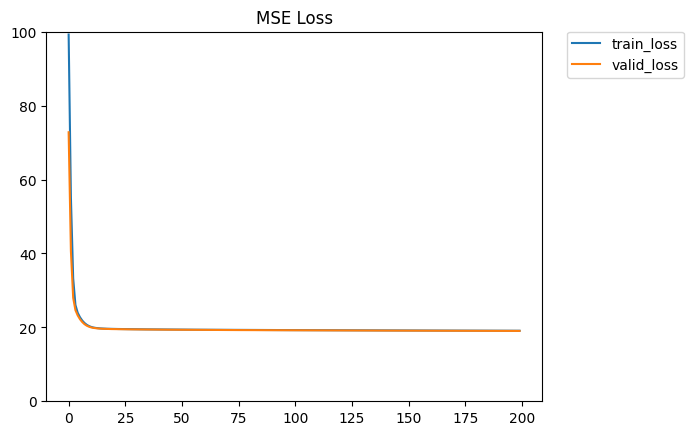

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.title('MSE Loss')
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
target_x , target_y = split_sequence(train_set.Elec_kW.values,n_steps)
inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)

In [ ]:
model.eval()
prediction = []
batch_size = 2
iterations =  int(inputs.shape[0]/2)

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
    prediction.append(preds.detach().numpy())

#### Prediction Result

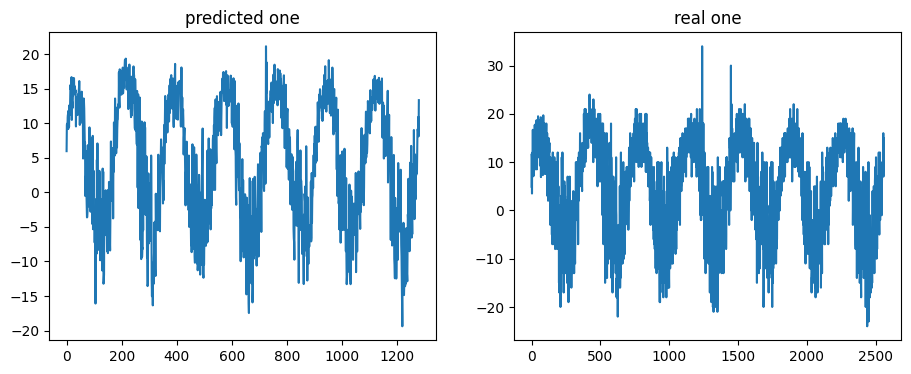

In [ ]:
fig, ax = plt.subplots(1, 2,figsize=(11,4))
ax[0].set_title('predicted one')
ax[0].plot(prediction)
ax[1].set_title('real one')
ax[1].plot(target_y)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define the path in Google Drive
drive_model_path = '/content/drive/My Drive/simple_nn.pth'

# Save the model
torch.save(model.state_dict(), drive_model_path)
print(f"Model saved to {drive_model_path}")


Model saved to /content/drive/My Drive/simple_nn.pth
